In [15]:
from scipy import stats
from tqdm import tqdm
import matplotlib.pyplot as plt
from functools import partial
from scipy.optimize import minimize
import optax
from jax import random, grad, vmap, jit
import jax.numpy as jnp
import jax
import pandas as pd
import numpy as np
import sys
import os

solver_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "solver"))
if solver_dir not in sys.path:
    sys.path.append(solver_dir)
from jkoSpinn import *

import matplotlib.pyplot as plt

In [ ]:
DT_OBS = 0.1
T_MAX = 2.0
BATCH_SIZE = 64
N_COLLOC = 256
X_DOMAIN = (-3.0, 3.0)


class PINN_Config:
    layers = [2, 10, 10, 10, 1]  # <-- Input dimension should be 2 (x,t) NOT 1
    lr = 1e-3
    w_nll = 10.0     # Data weight
    w_pde = 1.0     # PDE residual weight
    w_norm = 10.0   # Normalization weight (expensive constraint)

# ============================================================================
# Network (Output must be positive for probability density)
# ============================================================================

def init_pinn_params(key, layers):
    params = []
    keys = random.split(key, len(layers))
    for i in range(len(layers) - 1):
        w = random.normal(keys[i], (layers[i], layers[i + 1])) * jnp.sqrt(2 / layers[i])
        b = jnp.zeros(layers[i + 1])
        params.append((w, b))
    return params

def pinn_forward(params, x, t):
    # Always ensure x and t are (N,) arrays
    x = jnp.atleast_1d(x)
    t = jnp.atleast_1d(t)
    # Broadcast x and t to same length
    n = jnp.maximum(x.shape[0], t.shape[0])
    x = jnp.reshape(x, (-1,))
    t = jnp.reshape(t, (-1,))
    if x.shape[0] == 1 and t.shape[0] > 1:
        x = jnp.full_like(t, x[0])
    if t.shape[0] == 1 and x.shape[0] > 1:
        t = jnp.full_like(x, t[0])
    # If both are >1 and mismatched, error
    assert x.shape == t.shape, f"Incompatible broadcast shapes: {x.shape}, {t.shape}"
    inputs = jnp.stack([x, t], axis=-1)  # shape (N,2)
    h = inputs
    for w, b in params[:-1]:
        h = jax.nn.tanh(jnp.dot(h, w) + b)
    w_last, b_last = params[-1]
    out = jnp.dot(h, w_last) + b_last
    # Force positivity via Softplus for density p(x,t)
    return jax.nn.softplus(out).reshape(-1)

# ============================================================================
# Physics & Loss
# ============================================================================

def fpe_residual(params_net, params_phys, x, t, process_type):
    """
    Compute Residual of Fokker-Planck Equation:
    dt_p = - dx(F*p) + 0.5 * dxx(D*p)
    """
    # Helper for gradients
    def p_fn(x_in, t_in):
        # Ensure x_in, t_in are 1D and of length 1
        x_arr = jnp.atleast_1d(x_in)
        t_arr = jnp.atleast_1d(t_in)
        return pinn_forward(params_net, x_arr, t_arr)[0]

    p = p_fn(x, t)
    p_t = grad(p_fn, argnums=1)(x, t)
    p_x = grad(p_fn, argnums=0)(x, t)
    p_xx = grad(grad(p_fn, argnums=0), argnums=0)(x, t)

    if process_type == "OU":
        theta, mu, D = params_phys["theta"], params_phys["mu"], params_phys["D"]
        # Drift F = -theta(x-mu) -> F' = -theta
        F = -theta * (x - mu)
        div_Fp = -theta * p + F * p_x
    else:  # Double Well
        alpha, D = params_phys["alpha"], params_phys["D"]
        # Drift F = -4alpha x (x^2-1) -> F' = -4alpha(3x^2 - 1)
        F = -4 * alpha * x * (x ** 2 - 1)
        div_F = -4 * alpha * (3 * x ** 2 - 1)
        div_Fp = div_F * p + F * p_x

    # Diffusion term: 0.5 * D * p_xx (assuming constant D)
    diff_term = 0.5 * D * p_xx

    # Residual: p_t + div(Fp) - diff_term = 0
    return (p_t + div_Fp - diff_term) ** 2

def normalization_integral(params_net, t_batch, domain):
    """
    Numerical integration to enforce int p(x,t) dx = 1.
    This is the computational bottleneck of standard PINNs.
    """
    x_grid = jnp.linspace(domain[0], domain[1], 100)  # Integration grid
    dx = x_grid[1] - x_grid[0]

    def integrate_at_t(t_val):
        # p_vals shape: (len(x_grid),)
        p_vals = pinn_forward(params_net, x_grid, jnp.full_like(x_grid, t_val))
        integral = jnp.sum(p_vals) * dx
        return (integral - 1.0) ** 2

    # Vectorize over time batch
    return jnp.mean(vmap(integrate_at_t)(t_batch))

def loss_pinn(params_net, params_phys, batch_data, batch_colloc, process_type):
    x_obs, t_obs = batch_data
    x_c, t_c = batch_colloc

    # 1. Data Loss: Negative Log Likelihood
    # Maximize log(p(data)), so minimize -log(p(data))
    p_pred = pinn_forward(params_net, x_obs, t_obs)
    # Add epsilon to avoid log(0)
    L_nll = -jnp.mean(jnp.log(p_pred + 1e-6))

    # 2. PDE Residual
    res_fn = vmap(lambda x, t: fpe_residual(params_net, params_phys, x, t, process_type))
    L_pde = jnp.mean(res_fn(x_c, t_c))

    # 3. Normalization Constraint (Expensive!)
    # Check normalization at collocation times
    L_norm = normalization_integral(params_net, t_c, X_DOMAIN)

    return PINN_Config.w_nll * L_nll + PINN_Config.w_pde * L_pde + PINN_Config.w_norm * L_norm

# ============================================================================
# Training
# ============================================================================

def train_pinn(x_train, t_train, process_type="OU", n_epochs=5000):
    key = random.PRNGKey(42)

    # Init Net
    key, k1 = random.split(key)
    params_net = init_pinn_params(k1, PINN_Config.layers)

    # Init Phys Params
    key, k2 = random.split(key)
    if process_type == "OU":
        params_phys = {
            "theta": random.uniform(k2, shape=(), minval=0.5, maxval=3.0),
            "mu": random.uniform(k2, shape=(), minval=-1.0, maxval=1.0),
            "D": random.uniform(k2, shape=(), minval=0.1, maxval=1.0)
        }
    else:
        params_phys = {
            "alpha": random.uniform(k2, shape=(), minval=0.5, maxval=2.0),
            "D": random.uniform(k2, shape=(), minval=0.2, maxval=1.5)
        }

    optimizer = optax.adam(PINN_Config.lr)
    opt_state = optimizer.init((params_net, params_phys))

    @jax.jit
    def step(p_net, p_phys, opt_st, b_data, b_colloc):
        grads = jax.grad(lambda p: loss_pinn(
            p[0], p[1], b_data, b_colloc, process_type))((p_net, p_phys))
        updates, new_opt_st = optimizer.update(grads, opt_st)
        new_params = optax.apply_updates((p_net, p_phys), updates)

        # Constraint positive D, theta, alpha
        new_phys = new_params[1]
        new_phys = dict(new_phys)
        new_phys["D"] = jnp.maximum(new_phys["D"], 1e-4)
        if "theta" in new_phys:
            new_phys["theta"] = jnp.maximum(new_phys["theta"], 1e-4)
        if "alpha" in new_phys:
            new_phys["alpha"] = jnp.maximum(new_phys["alpha"], 1e-4)

        return new_params[0], new_phys, new_opt_st

    # Loop
    hist = {k: [] for k in params_phys}
    pbar = tqdm(range(n_epochs), desc=f"PINN {process_type}")

    for _ in pbar:
        key, k1, k2 = random.split(key, 3)
        # Data batch
        idx = random.choice(k1, len(x_train), shape=(BATCH_SIZE,))
        b_data = (x_train[idx], t_train[idx])
        # Collocation batch
        xc = random.uniform(
            k2, (N_COLLOC,), minval=X_DOMAIN[0], maxval=X_DOMAIN[1])
        tc = random.uniform(k2, (N_COLLOC,), minval=0, maxval=T_MAX)
        b_colloc = (xc, tc)

        params_net, params_phys, opt_state = step(
            params_net, params_phys, opt_state, b_data, b_colloc)

        for k in params_phys:
            hist[k].append(float(params_phys[k]))
        pbar.set_postfix(
            {k: f"{float(v):.3f}" for k, v in params_phys.items()})

    return params_phys, hist


In [ ]:
class MLE_Solver:

    @staticmethod
    def ou_negative_log_likelihood(params, X, dt):
        """
        Exact MLE for Ornstein-Uhlenbeck.
        Params: [theta, mu, sigma] (Note: D = sigma^2 / 2 usually, but let's stick to sde form)
        Model: dX = -theta(X-mu)dt + sigma dW
        """
        theta, mu, sigma = params
        if theta <= 0 or sigma <= 0:
            return 1e9

        # Exact transition density moments
        # Mean: mu + (x_t - mu) * exp(-theta * dt)
        # Var:  (sigma^2 / (2*theta)) * (1 - exp(-2*theta*dt))

        x_curr = X[:-1]
        x_next = X[1:]

        mean_trans = mu + (x_curr - mu) * np.exp(-theta * dt)
        var_trans = (sigma**2 / (2*theta)) * (1.0 - np.exp(-2*theta * dt))

        # Prevent division by zero in relative error calculations downstream:
        var_trans = np.where(np.abs(var_trans) < 1e-12, 1e-12, var_trans)

        # Log Likelihood Gaussian
        nll = 0.5 * np.log(2 * np.pi * var_trans) + 0.5 * ((x_next - mean_trans)**2) / var_trans

        return np.sum(nll)

    @staticmethod
    def dw_negative_log_likelihood(params, X, dt):
        """
        Euler-Maruyama Pseudo-Likelihood for Double Well.
        Model: dX = -4*alpha*X*(X^2 - 1)dt + sigma dW
        Approx: X_{t+1} ~ N(X_t + F(X_t)dt, sigma^2 dt)
        """
        alpha, sigma = params
        if alpha <= 0 or sigma <= 0:
            return 1e9

        x_curr = X[:-1]
        x_next = X[1:]

        # Drift F(x)
        drift = -4 * alpha * x_curr * (x_curr**2 - 1)

        # Euler moments
        mean_trans = x_curr + drift * dt
        var_trans = sigma**2 * dt

        var_trans = np.where(np.abs(var_trans) < 1e-12, 1e-12, var_trans)

        nll = 0.5 * np.log(2 * np.pi * var_trans) + 0.5 * ((x_next - mean_trans)**2) / var_trans

        return np.sum(nll)

    @staticmethod
    def fit(X_obs, dt_obs, model_type="OU"):
        """Wrapper for Scipy Minimize"""
        X_flat = np.array(
            X_obs)  # Flatten if needed, but assuming single long traj or concatenated

        if model_type == "OU":
            # Initial guess: theta=1, mu=0, sigma=1
            x0 = [1.0, 0.0, 1.0]
            bounds = [(1e-3, 10), (-5, 5), (1e-3, 5)]
            res = minimize(MLE_Solver.ou_negative_log_likelihood, x0, args=(X_flat, dt_obs), bounds=bounds, method='L-BFGS-B')
            # Ensure sigma > 0 for reporting sigma, NEVER allow division by zero downstream
            sigma = res.x[2] if abs(res.x[2]) > 1e-12 else 1e-12
            return {"theta": res.x[0], "mu": res.x[1], "sigma": sigma}

        elif model_type == "DoubleWell":
            # Initial guess: alpha=1, sigma=1
            x0 = [1.0, 1.0]
            bounds = [(1e-3, 5), (1e-3, 5)]
            res = minimize(MLE_Solver.dw_negative_log_likelihood, x0, args=(X_flat, dt_obs), bounds=bounds, method='L-BFGS-B')
            sigma = res.x[1] if abs(res.x[1]) > 1e-12 else 1e-12
            return {"alpha": res.x[0], "sigma": sigma}

In [20]:
config = Config()  # From JKO code
key = random.PRNGKey(42)

# ==========================================
# 1. OU Benchmark
# ==========================================
print("\n" + "="*50)
print("BENCHMARK: ORNSTEIN-UHLENBECK")
print("="*50)

ou_proc = OUProcess(theta = 1.7, mu = 0.15, sigma = 0.7)
key, k_data = random.split(key)
data_ou = generate_data(k_data, ou_proc, config)

# A. Run JKO-SPINN
print("--- Running JKO-SPINN ---")
key, k_jko = random.split(key)
_, p_jko, _ = train_jko_spinn(k_jko, data_ou, ou_proc, config, verbose=True)

# B. Run Standard PINN
true_ou = ou_proc.get_true_params()
print(true_ou)
print("--- Running PINNs ---")
p_pinn, _ = train_pinn(data_ou["observations"], data_ou["times"], "OU", n_epochs=5000)

# C. Run MLE
print("--- Running MLE ---")
p_mle = MLE_Solver.fit(data_ou["observations"], config.dt_obs, "OU")

# Compare
df_ou = pd.DataFrame(
    [
        true_ou,
        {"theta": p_jko["theta"], "mu": p_jko["mu"], "sigma": np.sqrt(p_jko["D"])},
        {"theta": p_pinn["theta"], "mu": p_pinn["mu"], "sigma": np.sqrt(p_pinn["D"])},
        p_mle,
    ],
    index=["True", "JKO-SPINN", "PINNs", "MLE"]
)

# Calculate RE%
df_err_ou = df_ou.copy()
for col in df_ou.columns:
    truth = df_ou.loc["True", col]
    df_err_ou[col] = np.abs(df_ou[col] - truth) / np.abs(truth) * 100
df_err_ou.loc["True"] = 0.0

print("\nResults OU (Values):")
print(df_ou)
print("\nResults OU (Rel Error %):")
print(df_err_ou)

# ==========================================
# 2. Double Well Benchmark
# ==========================================
print("\n" + "="*50)
print("BENCHMARK: DOUBLE WELL")
print("="*50)

dw_proc = DoubleWellProcess(alpha=1.0, sigma=0.8)
key, k_data = random.split(key)
data_dw = generate_data(k_data, dw_proc, config)

# A. Run JKO-SPINN
print("--- Running JKO-SPINN ---")
key, k_jko = random.split(key)
_, p_jko_dw, _ = train_jko_spinn(k_jko, data_dw, dw_proc, config, verbose=True)

# B. Run Standard PINN
true_dw = dw_proc.get_true_params()
print(true_dw)
print("--- Running PINNs ---")
p_pinn_dw, _ = train_pinn(data_dw["observations"], data_dw["times"], "DoubleWell", n_epochs=5000)

# C. Run MLE
print("--- Running MLE (Euler Approx) ---")
p_mle_dw = MLE_Solver.fit(data_dw["observations"], config.dt_obs, "DoubleWell")

# Compare
df_dw = pd.DataFrame(
    [
        true_dw,
        {"alpha": p_jko_dw["alpha"], "sigma": np.sqrt(p_jko_dw["D"])},
        {"alpha": p_pinn_dw["alpha"], "sigma": np.sqrt(p_pinn_dw["D"])},
        p_mle_dw
    ],
    index=["True",  "JKO-SPINN",  "PINNs",  "MLE"]
)

# Calculate RE%
df_err_dw = df_dw.copy()
for col in df_dw.columns:
    truth = df_dw.loc["True", col]
    df_err_dw[col] = np.abs(df_dw[col] - truth) / np.abs(truth) * 100
df_err_dw.loc["True"] = 0.0

print("\nResults Double Well (Values):")
print(df_dw)
print("\nResults Double Well (Rel Error %):")
print(df_err_dw)


BENCHMARK: ORNSTEIN-UHLENBECK


--- Running JKO-SPINN ---


100%|██████████| 5000/5000 [01:00<00:00, 83.22it/s, L=0.126451, D=0.49201047, mu=0.15000038, theta=1.69982338, sigma=0.70143461]   


{'theta': 1.7, 'mu': 0.15, 'sigma': 0.7}
--- Running PINNs ---


PINN OU: 100%|██████████| 5000/5000 [01:28<00:00, 56.63it/s, D=0.119, mu=0.107, theta=0.544]


--- Running MLE ---

Results OU (Values):
               theta          mu     sigma
True             1.7        0.15  0.700000
JKO-SPINN  1.6998234  0.15000038  0.701435
PINNs      0.5443012  0.10679607  0.344540
MLE              1.0         0.0  1.000000

Results OU (Rel Error %):
                 theta             mu      sigma
True               0.0            0.0   0.000000
JKO-SPINN  0.010392245  0.00024835268   0.204945
PINNs         67.98228      28.802622  50.779966
MLE          41.176471          100.0  42.857143

BENCHMARK: DOUBLE WELL
--- Running JKO-SPINN ---


100%|██████████| 5000/5000 [00:59<00:00, 83.40it/s, L=80.331917, D=0.63299948, alpha=0.95193183]    


{'alpha': 1.0, 'sigma': 0.8}
--- Running PINNs ---


PINN DoubleWell: 100%|██████████| 5000/5000 [01:24<00:00, 58.86it/s, D=1.711, alpha=0.952]


--- Running MLE (Euler Approx) ---

Results Double Well (Values):
                alpha     sigma
True              1.0  0.800000
JKO-SPINN  0.95193183  0.795613
PINNs       0.9517688  1.307867
MLE               1.0  1.000000

Results Double Well (Rel Error %):
               alpha      sigma
True             0.0   0.000000
JKO-SPINN  4.8068166   0.548421
PINNs       4.823118  63.483337
MLE              0.0  25.000000


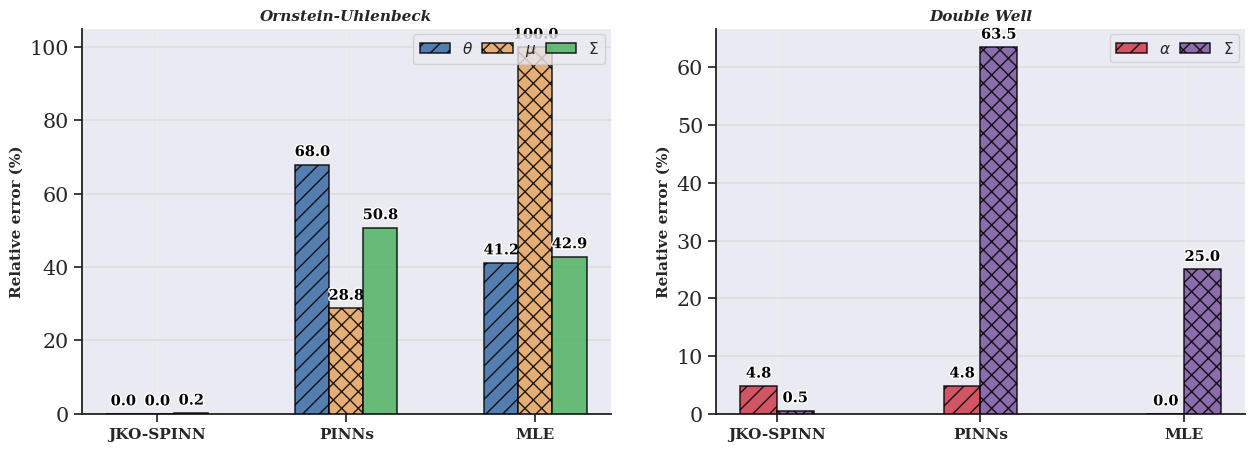

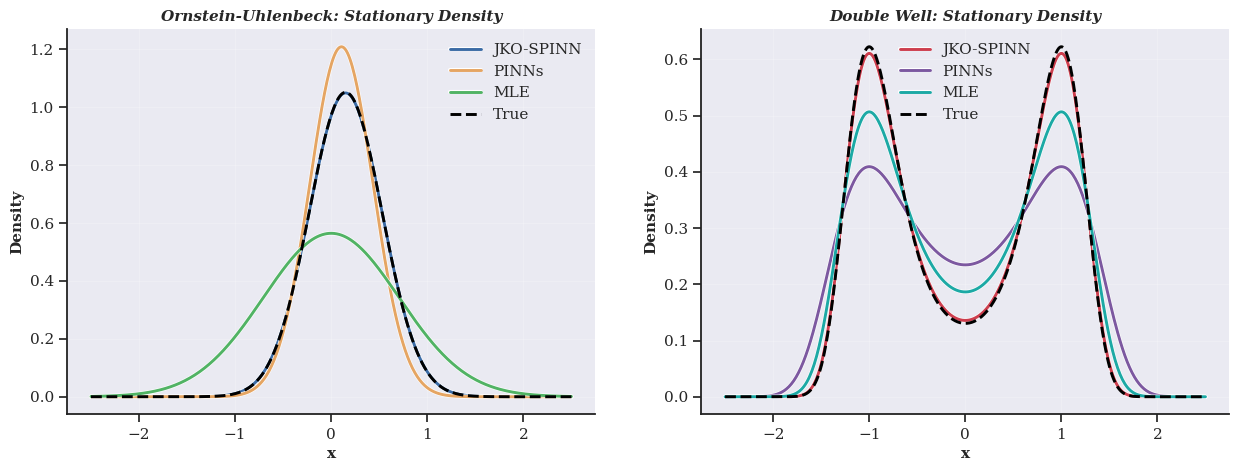

In [35]:
import seaborn as sns
import matplotlib.patheffects as PathEffects

# Pour un style scientifique épuré et moderne !
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_context("notebook", font_scale=1.35)
sns.set_palette("colorblind")
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "axes.edgecolor": "#222222",
    "axes.linewidth": 1.3,
    "grid.alpha": 0.18,
    "axes.titleweight": "bold",
    "axes.labelweight": "bold"
})

ou_param_colors = {
    "theta": "#3b6ba5",  # blue
    "mu": "#e5a563",     # orange
    "sigma": "#51b364"   # green
}
dw_param_colors = {
    "alpha": "#cd3e4e",  # red
    "sigma": "#7c58a0"   # purple
}

ou_param_latex = {
    "theta": r"$\theta$",
    "mu": r"$\mu$",
    "sigma": r"$\Sigma$",
}
dw_param_latex = {
    "alpha": r"$\alpha$",
    "sigma": r"$\Sigma$",
}
method_order_ou = ["JKO-SPINN", "PINNs", "MLE"]
method_order_dw = ["JKO-SPINN", "PINNs", "MLE"]

# Fancy barplot function
def fancy_grouped_bar(ax, df, colors, latex_labels, bar_width=0.18, title="", show_legend=True):
    x = np.arange(df.shape[0])
    n_params = df.shape[1]
    for i, param in enumerate(df.columns):
        vals = df[param].values
        bar = ax.bar(
            x + (i - (n_params-1)/2) * bar_width,
            vals,
            width=bar_width,
            color=colors.get(param, "#333"),
            edgecolor="k",
            linewidth=1.1,
            alpha=0.86,
            label=latex_labels.get(param, param),
            zorder=3,
            hatch="//" if param == list(df.columns)[0] else "xx" if i==1 else ""
        )
        # Add values on top with nice text effects
        for rect in bar:
            height = rect.get_height()
            txt = ax.text(
                rect.get_x() + rect.get_width()/2, height + max(df.max())*0.015,
                f"{height:.1f}",
                ha='center', va='bottom',
                fontsize=10.5, weight="bold", color="black",
                path_effects=[PathEffects.withStroke(linewidth=2, foreground="white")]
            )
    ax.set_xticks(x)
    ax.set_xticklabels(df.index, fontsize=11, weight="bold")
    ax.set_ylabel("Relative error (%)", fontsize=11, weight="bold")
    ax.set_title(title, fontsize=11, weight="bold", style="italic")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_axisbelow(True)
    ax.yaxis.grid(True, which='major', color='#bbbbbb', alpha=0.25, linewidth=1.4)
    if show_legend:
        ax.legend(
            fontsize=11, loc="upper right", frameon=True,
            fancybox=True, ncol=n_params, borderaxespad=0.35,
            labelspacing=0.25, columnspacing=0.6
        )

# --- Barplots for relative errors ---
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Ornstein-Uhlenbeck
err_ou = df_err_ou.loc[method_order_ou].copy()
fancy_grouped_bar(
    axes[0], err_ou, ou_param_colors, ou_param_latex,
    title="Ornstein-Uhlenbeck", show_legend=True
)

# Double Well
err_dw = df_err_dw.loc[method_order_dw].copy()
fancy_grouped_bar(
    axes[1], err_dw, dw_param_colors, dw_param_latex,
    title="Double Well", show_legend=True
)

# Save the barplot figure in high resolution
# fig.tight_layout(pad=2.2)
fig.savefig("barplot_relative_errors.png", dpi=300, bbox_inches='tight')

# -- Scientific addition: plot the stationary densities (estimated vs. true) for PINNs, JKO-SPINN, and MLE --

def plot_stationary_density(ax, x_grid, densities, labels, colors, styles, zorders, title):
    # To ensure 'True' is on top, plot others first, then 'True'
    for dens, label, color, style, z in zip(densities, labels, colors, styles, zorders):
        # For 'True', use higher zorder so it's on top and dashed
        ax.plot(
            x_grid, dens, lw=2.1, label=label, color=color,
            linestyle=style,
            zorder=z,
            path_effects=[PathEffects.withStroke(linewidth=3, foreground='white')] if style == '-' else None
        )
    ax.set_xlabel("x", fontsize=11)
    ax.set_ylabel("Density", fontsize=11)
    ax.set_title(title, fontsize=11, weight="bold", style="italic")
    ax.legend(fontsize=11)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, alpha=0.2)
    ax.tick_params(axis="both", which="major", labelsize=11)

# --- Ornstein-Uhlenbeck densities ---
x_grid_ou = np.linspace(-2.5, 2.5, 400)
ou_proc_true = OUProcess(**df_ou.loc["True"].to_dict())
ou_proc_jko = OUProcess(
    theta=df_ou.loc["JKO-SPINN", "theta"], 
    mu=df_ou.loc["JKO-SPINN", "mu"], 
    sigma=df_ou.loc["JKO-SPINN", "sigma"]
)
ou_proc_pinn = OUProcess(
    theta=df_ou.loc["PINNs", "theta"], 
    mu=df_ou.loc["PINNs", "mu"], 
    sigma=df_ou.loc["PINNs", "sigma"]
)
ou_proc_mle = OUProcess(
    theta=df_ou.loc["MLE", "theta"], 
    mu=df_ou.loc["MLE", "mu"],
    sigma=df_ou.loc["MLE", "sigma"]
)
# Prepare densities and labels *with MLE*
densities_ou = [
    ou_proc_jko.stationary_density(x_grid_ou),
    ou_proc_pinn.stationary_density(x_grid_ou),
    ou_proc_mle.stationary_density(x_grid_ou),
    ou_proc_true.stationary_density(x_grid_ou)
]
labels_ou = [
    r"JKO-SPINN", r"PINNs", r"MLE", r"True"
]
colors_ou = ["#3b6ba5", "#e5a563", "#51b364", "black"]
# True is last, to be dashed and on top
styles_ou = ["-", "-", "-", "--"]
zorders_ou = [2, 2, 2, 8]

# --- Double Well densities ---
x_grid_dw = np.linspace(-2.5, 2.5, 400)
dw_proc_true = DoubleWellProcess(**df_dw.loc["True"].to_dict())
dw_proc_jko = DoubleWellProcess(
    alpha=df_dw.loc["JKO-SPINN", "alpha"], 
    sigma=df_dw.loc["JKO-SPINN", "sigma"]
)
dw_proc_pinn = DoubleWellProcess(
    alpha=df_dw.loc["PINNs", "alpha"], 
    sigma=df_dw.loc["PINNs", "sigma"]
)
dw_proc_mle = DoubleWellProcess(
    alpha=df_dw.loc["MLE", "alpha"], 
    sigma=df_dw.loc["MLE", "sigma"]
)

# Patch for DoubleWellProcess.stationary_density: Use numpy.trapz, not jax.numpy.trapz, to avoid AttributeError!
def dw_stationary_density_numpy(self, x):
    D = self.sigma ** 2
    potential = self.potential(x)
    unnormalized = np.exp(-potential / D)
    x_grid = np.linspace(-4, 4, 200)
    Z = np.trapz(np.exp(-self.potential(x_grid) / D), x_grid)
    return unnormalized / Z

# Monkeypatch if needed (in case jnp.trapz missing -- as in JAX >= 0.4.20)
DoubleWellProcess.stationary_density = dw_stationary_density_numpy

densities_dw = [
    dw_proc_jko.stationary_density(x_grid_dw),
    dw_proc_pinn.stationary_density(x_grid_dw),
    dw_proc_mle.stationary_density(x_grid_dw),
    dw_proc_true.stationary_density(x_grid_dw)
]
labels_dw = [
    r"JKO-SPINN", r"PINNs", r"MLE", r"True"
]
colors_dw = ["#cd3e4e", "#7c58a0", "#1ca9a5", "black"]
styles_dw = ["-", "-", "-", "--"]
zorders_dw = [2, 2, 2, 8]

# -- Plot the densities ---
fig2, axes2 = plt.subplots(1, 2, figsize=(15, 5))
plot_stationary_density(
    axes2[0], x_grid_ou, densities_ou, labels_ou, colors_ou, styles_ou, zorders_ou,
    title="Ornstein-Uhlenbeck: Stationary Density"
)
plot_stationary_density(
    axes2[1], x_grid_dw, densities_dw, labels_dw, colors_dw, styles_dw, zorders_dw,
    title="Double Well: Stationary Density"
)

# Save the density figure in high resolution
# fig2.tight_layout(pad=3.0)
fig2.savefig("stationary_densities.png", dpi=300, bbox_inches='tight')

plt.show()